In [6]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from statsmodels.multivariate.manova import MANOVA
from sklearn.utils import resample

In [2]:
def mardia_test(df):
    # n; number of samples; p: number of variables (metabolites)
    n, p = df.shape
    # Substract each value its column mean
    data = df - df.mean()
    #Get covariance matrix inverted
    S = data.cov()
    SI = np.linalg.inv(S)
    
    
    # Check if inverse is right with identity matrix
    # df_SI = pd.DataFrame(SI)
    # df_SI.to_excel('SI.xlsx')
    # print(df_SI)
    # I =np.dot(S,SI)
    # df_I = pd.DataFrame(I)
    # df_I.to_excel('I.xlsx')
    
    # Turn NaN to 0 so when there are multiplications there's no problem
    data = data.replace(np.nan, 0)
    
    D = np.dot(np.dot(data, SI) , data.T)
    
    # Mardia test
    g1p = np.sum(D**3) / n**2
    g2p = np.sum(np.diag(D**2)) / n
    dfree = p * (p + 1) * (p + 2) / 6
    k = ((p + 1)*(n + 1)*(n + 3))/(n*((n + 1)*(p + 1) - 6))
    
    if n < 20:
        skew = n * k * g1p / 6
        p_skew = 1 - stats.chi2.cdf(skew, dfree)
    else:
        skew = n * g1p / 6
        p_skew = 1 - stats.chi2.cdf(skew, dfree)
    
    kurt = (g2p - p * (p + 2)) * np.sqrt(n/(8 * p * (p + 2)))
    p_kurt = 2 * (1 - stats.norm.cdf(abs(kurt)))
    
    skewMVN = "YES" if p_skew > 0.05 else "NO"
    kurtoMVN = "YES" if p_kurt > 0.05 else "NO"
    
    MVN = "YES" if p_kurt > 0.05 and p_skew > 0.05 else "NO"
    
    # result = np.column_stack((["Mardia"], g1p, skew, p_skew, skewMVN, g2p, kurt, p_kurt, kurtoMVN, MVN))
    # result = pd.DataFrame(result, columns=["test", "g1p", "chi.skew", "p.value.skew", "skewnewss", "g2p", "z.kurtosis", "p.value.kurt", "kurtosis", "MVN"])
    
    resultSkewness = pd.DataFrame({"Test": ["Mardia Skewness"], "Statistic": [skew], "p value": [p_skew], "Result": [skewMVN]})
    resultKurtosis = pd.DataFrame({"Test": ["Mardia Kurtosis"], "Statistic": [kurt], "p value": [p_kurt], "Result": [kurtoMVN]})
    MVNresult = pd.DataFrame({"Test": ["MVN"], "Statistic": [np.nan], "p value": [np.nan], "Result": [MVN]})
    
    result = pd.concat([resultSkewness, resultKurtosis, MVNresult], ignore_index=True)
    
    print(result)
   
    d = np.diag(D)
    r = stats.rankdata(d)
    # print(d,r)
    chi2q = stats.chi2.ppf((r - 0.5) / n, p)

    
    substraction = np.abs(chi2q - d)
    mean = np.mean(substraction)
    deviation = np.std(substraction)
    # print(substraction, mean, deviation)
    
    # Calculate upper/lower threshold 
    d_upper_limit = chi2q + mean + 2*deviation
    d_lower_limit = chi2q - mean - 2*deviation
    
    # Identify outliers
    outliers = d > d_upper_limit
    outliers |= d < d_lower_limit
    
    # Plot all dots
    plt.scatter(d[~outliers], chi2q[~outliers], marker='x', c='blue', label='Non-Outliers')
    plt.scatter(d[outliers], chi2q[outliers], marker='o', c='red', label='Outliers')
    
    # Label only outliers
    # for i, txt in enumerate(df.index):
    #     if outliers[i]: #If you add not will show NORMAL/TYPICAL VALUES
    #         plt.annotate(txt, (d[i], chi2q[i]))
    #         print(txt)
    for i, txt in enumerate(df.index):
        if outliers[i]: #If you add not will show NORMAL/TYPICAL VALUES
            plt.annotate(txt, (d[i], chi2q[i]))
            print(txt)
    
    # Line with slope 1 passing through the origin
    # x_line = np.linspace(81, 100, 100)  # Genera 100 puntos entre 0 y 1
    x_line = np.linspace(np.min(d), np.max(d), 100)  # 100 points between max and min values
    # If we use same ponits for both axes we get a line with slop 1 ;)
    plt.plot(x_line, x_line, color='green', linestyle='-', linewidth=2, label='Identity Line')
    plt.title("Chi-Square Q-Q Plot")
    plt.xlabel("Squared Mahalanobis Distance")
    plt.ylabel("Chi-Square Quantile")
    plt.legend()
    plt.grid()
    
    plt.show()
    df = df.drop(df.index[outliers])
    print(df)
    df.to_excel("data.xlsx")

              Test  Statistic   p value Result
0  Mardia Skewness  90.679546  0.978788    YES
1  Mardia Kurtosis  -2.302585  0.021302     NO
2              MVN        NaN       NaN     NO
c9


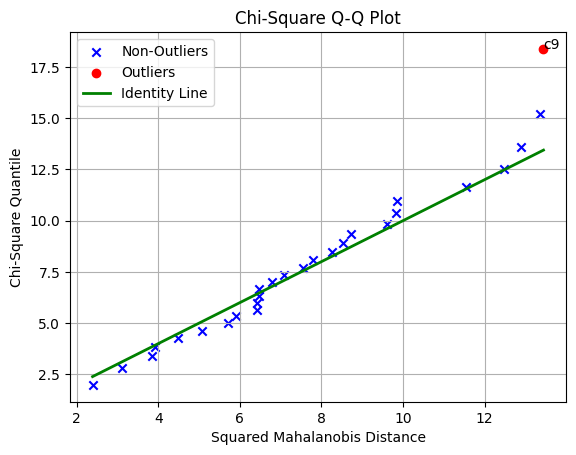

               C0  C3-DC (C4-OH)        C9     C12:1    Ac-Orn  Putrescine  \
Sample                                                                       
c1       6.744444       0.008217  0.012667  0.037000  0.263222    0.170111   
c2       7.400000       0.008217  0.011000  0.045367  0.051333    0.154000   
c3       7.733333       0.008217  0.012450  0.037000  0.260667    0.118333   
c4       7.466667       0.008217  0.010667  0.046000  0.241667    0.120667   
c5       7.800000       0.008217  0.014333  0.037000  0.366667    0.131667   
c6       8.466667       0.008333  0.011000  0.047000  0.613333    0.098000   
c7       3.400000       0.008217  0.012783  0.047421  0.157000    0.070333   
c8       9.533333       0.008900  0.011000  0.038667  0.291333    0.092000   
c10     10.033333       0.006500  0.011333  0.038333  0.255167    0.185167   
c11      5.727273       0.008217  0.012783  0.047273  0.135000    0.136272   
RF_137  10.950000       0.006750  0.015250  0.044750  0.246750  

In [3]:
df= pd.read_excel(r'PATH')
df.set_index('Sample', inplace=True)
# print(df)
mardia_test(df)

df= pd.read_excel('data.xlsx')
type_sample = pd.read_excel('PATH', sheet_name='Data_4')
type_sample = type_sample[['Sample', 'Disease']]
df = pd.merge(df, type_sample, on='Sample', how='inner')
df.set_index('Sample', inplace=True)
df['Disease_2'] = df['Disease'].apply(lambda x: 'C' if x == 'C' else 'P')
df = df.rename(columns={'C3-DC (C4-OH)': 'C3', 'C12:1': 'C12', 'Ac-Orn': 'AcOrn'})
print(df.columns)
df.to_excel("data_disease.xlsx")
manova = MANOVA.from_formula('C0 + C3 + C9 + C12 + AcOrn + Putrescine + SDMA + Spermidine ~ Disease_2', data=df)
result = manova.mv_test()
print(result)
print(df)
